In [5]:
import pandas as pd

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog


image = cv2.imread('/content/img1.png', cv2.IMREAD_GRAYSCALE)

In [7]:
def applyBlobDetection(img_path):
  image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  blurred = cv2.GaussianBlur(image, (5, 5), 0)
  log_result = cv2.Laplacian(blurred, cv2.CV_64F)
  gaussian1 = cv2.GaussianBlur(image, (3, 3), 1)
  gaussian2 = cv2.GaussianBlur(image, (5, 5), 2)
  dog_result = gaussian1 - gaussian2
  hog_result, _ = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)
  fig, axes = plt.subplots(1, 4, figsize=(15, 5))
  axes[0].imshow(image, cmap='gray')
  axes[0].set_title('Original Image')

  axes[1].imshow(log_result, cmap='gray')
  axes[1].set_title('LoG (Laplacian of Gaussian)')

  axes[2].imshow(dog_result, cmap='gray')
  axes[2].set_title('DoG (Difference of Gaussian)')

  axes[3].imshow(hog_result, cmap='gray')
  axes[3].set_title('HoG (Histogram of Oriented Gradients)')

  for ax in axes:
      ax.axis('off')

  plt.show()





TypeError: Invalid shape (104904,) for image data

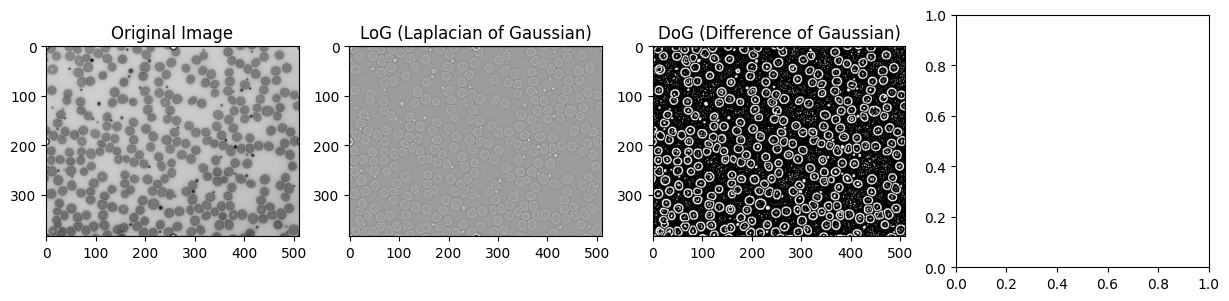

In [9]:
applyBlobDetection('/content/img1.png')

TypeError: Invalid shape (132912,) for image data

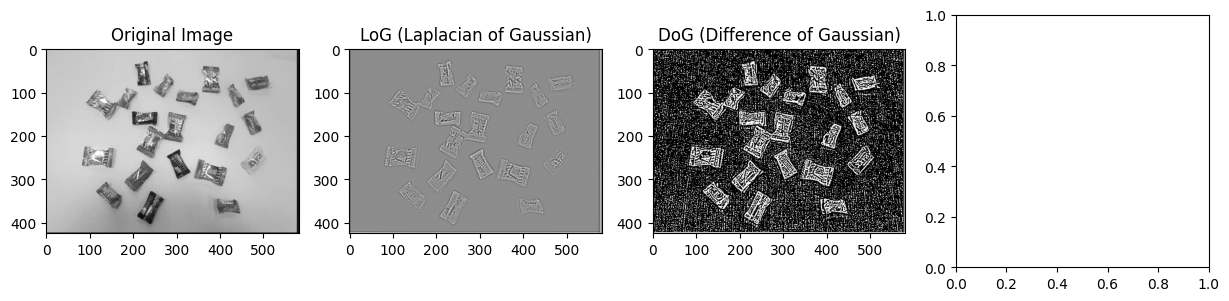

In [10]:
applyBlobDetection('/content/img2.png')

## Image quality enhancement

In [11]:
image = cv2.imread('/content/img3.png')

In [12]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [13]:
alpha = 1.5  # Contrast
beta = 50    # Brightness
bright_contrast = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

In [14]:
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
sharpened = cv2.filter2D(image, -1, kernel)

## 3. Noise Removal (Gaussian Blur)
denoised = cv2.GaussianBlur(image, (5, 5), 0)

In [15]:
lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
l = clahe.apply(l)
enhanced_color = cv2.merge((l, a, b))
enhanced_color = cv2.cvtColor(enhanced_color, cv2.COLOR_LAB2BGR)

In [16]:
!wget https://github.com/Saafke/EDSR_Tensorflow/raw/master/models/EDSR_x4.pb

--2025-04-01 06:31:05--  https://github.com/Saafke/EDSR_Tensorflow/raw/master/models/EDSR_x4.pb
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Saafke/EDSR_Tensorflow/master/models/EDSR_x4.pb [following]
--2025-04-01 06:31:05--  https://raw.githubusercontent.com/Saafke/EDSR_Tensorflow/master/models/EDSR_x4.pb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38573255 (37M) [application/octet-stream]
Saving to: ‘EDSR_x4.pb’

EDSR_x4.pb          100%[===================>]  36.79M  --.-KB/s    in 0.09s   

2025-04-01 06:31:09 (401 MB/s) - ‘EDSR_x4.pb’ saved [38573255/38573255]



In [17]:
resized = cv2.resize(image, (500, 500), interpolation=cv2.INTER_CUBIC)

## 6. Inverse Transform (Negative Image)
inverse_transform = cv2.bitwise_not(image)

## 7. Histogram Equalization
equalized_gray = cv2.equalizeHist(gray)
equalized = cv2.cvtColor(equalized_gray, cv2.COLOR_GRAY2BGR)

## 8. Super-resolution (Using OpenCV DNN)
sr = cv2.dnn_superres.DnnSuperResImpl_create()
# Download the model file if you haven't already
!wget https://github.com/Saafke/EDSR_Tensorflow/raw/master/models/EDSR_x4.pb
sr.readModel("EDSR_x4.pb")  # Pre-trained model loaded
sr.setModel("edsr", 4)  # EDSR Model, Upscale factor 4
super_res = sr.upsample(image)


--2025-04-01 06:31:09--  https://github.com/Saafke/EDSR_Tensorflow/raw/master/models/EDSR_x4.pb
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Saafke/EDSR_Tensorflow/master/models/EDSR_x4.pb [following]
--2025-04-01 06:31:09--  https://raw.githubusercontent.com/Saafke/EDSR_Tensorflow/master/models/EDSR_x4.pb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38573255 (37M) [application/octet-stream]
Saving to: ‘EDSR_x4.pb.1’

EDSR_x4.pb.1        100%[===================>]  36.79M  --.-KB/s    in 0.1s    

2025-04-01 06:31:09 (348 MB/s) - ‘EDSR_x4.pb.1’ saved [38573255/38573255]



In [18]:
result_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
avg_a = np.mean(result_lab[:,:,1])
avg_b = np.mean(result_lab[:,:,2])
result_lab[:,:,1] = result_lab[:,:,1] - ((avg_a - 128) * (result_lab[:,:,0] / 255.0) * 1.1)
result_lab[:,:,2] = result_lab[:,:,2] - ((avg_b - 128) * (result_lab[:,:,0] / 255.0) * 1.1)
color_corrected = cv2.cvtColor(result_lab, cv2.COLOR_LAB2BGR)

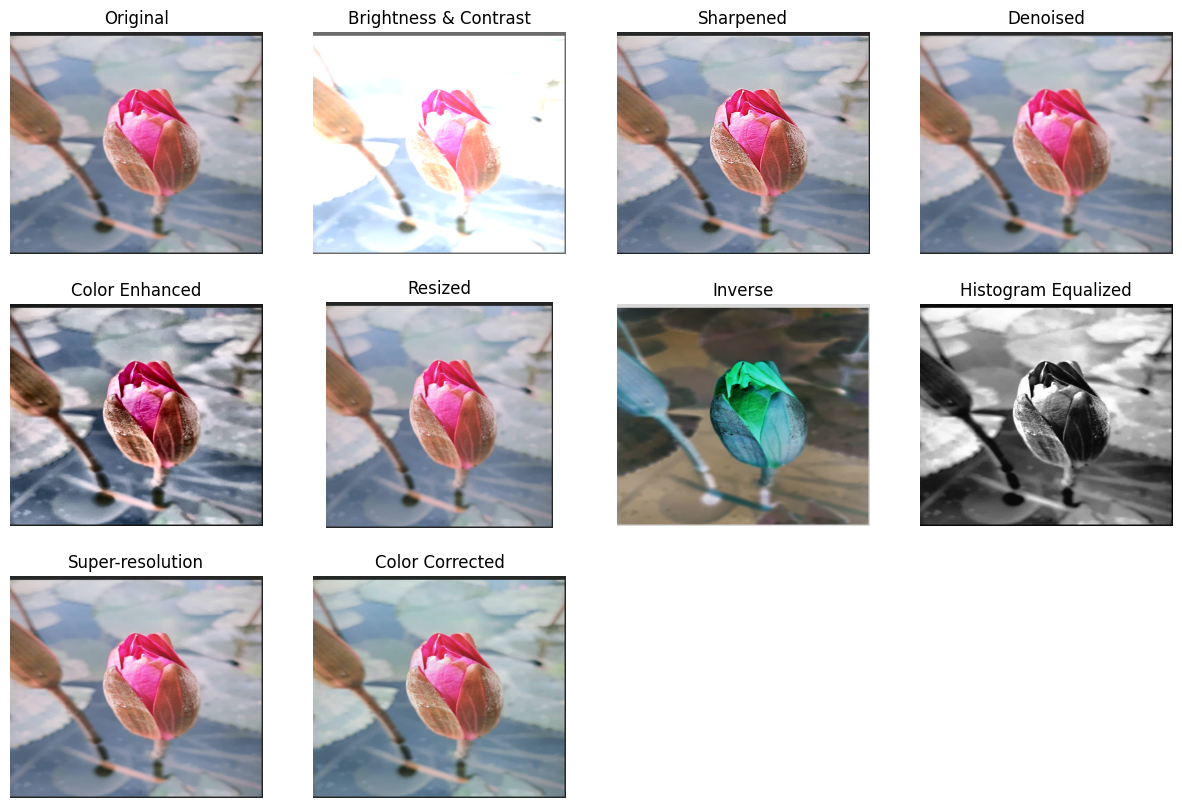

In [19]:
titles = ["Original", "Brightness & Contrast", "Sharpened", "Denoised",
          "Color Enhanced", "Resized", "Inverse", "Histogram Equalized", "Super-resolution", "Color Corrected"]
images = [image, bright_contrast, sharpened, denoised,
          enhanced_color, resized, inverse_transform, equalized, super_res, color_corrected]

plt.figure(figsize=(15,10))
for i in range(10):
    plt.subplot(3, 4, i+1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.axis('off')

plt.show()

In [20]:
!pip install deeplake

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 94.1 MB/s eta 0:00:00


In [22]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])


train_ds = torchvision.datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)
test_ds = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


100%|██████████| 169M/169M [00:18<00:00, 9.06MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [23]:
from torchvision import models
import torch.nn as nn


resnet18 = models.resnet18(pretrained=True)
resnet34 = models.resnet34(pretrained=True)


resnet18.fc = nn.Linear(resnet18.fc.in_features, 100)
resnet34.fc = nn.Linear(resnet34.fc.in_features, 100)


resnet18, resnet34 = resnet18.to(device), resnet34.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

In [24]:
import torch.optim as optim
from tqdm import tqdm

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizers
optimizer_18 = optim.Adam(resnet18.parameters(), lr=0.001)
optimizer_34 = optim.Adam(resnet34.parameters(), lr=0.001)

# Training function
def train_model(model, optimizer, train_loader, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct, total = 0, 0
        loop = tqdm(train_loader, leave=True)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item(), acc=100*correct/total)

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")

# Train ResNet-18
print("Training ResNet-18...")
train_model(resnet18, optimizer_18, train_loader)

# Train ResNet-34
print("\nTraining ResNet-34...")
train_model(resnet34, optimizer_34, train_loader)


Training ResNet-18...


Epoch [1/5]: 100%|██████████| 391/391 [00:21<00:00, 18.55it/s, acc=32.3, loss=2.22]


Epoch 1, Loss: 2.6832, Accuracy: 32.33%


Epoch [2/5]: 100%|██████████| 391/391 [00:18<00:00, 21.16it/s, acc=48, loss=1.96]


Epoch 2, Loss: 1.9209, Accuracy: 47.99%


Epoch [3/5]: 100%|██████████| 391/391 [00:18<00:00, 21.48it/s, acc=55.8, loss=1.53]


Epoch 3, Loss: 1.5676, Accuracy: 55.82%


Epoch [4/5]: 100%|██████████| 391/391 [00:19<00:00, 20.07it/s, acc=62.3, loss=1.28]


Epoch 4, Loss: 1.3079, Accuracy: 62.30%


Epoch [5/5]: 100%|██████████| 391/391 [00:18<00:00, 21.38it/s, acc=68, loss=1.15]


Epoch 5, Loss: 1.0864, Accuracy: 67.98%

Training ResNet-34...


Epoch [1/5]: 100%|██████████| 391/391 [00:22<00:00, 17.25it/s, acc=30.2, loss=2.79]


Epoch 1, Loss: 2.7818, Accuracy: 30.21%


Epoch [2/5]: 100%|██████████| 391/391 [00:22<00:00, 17.27it/s, acc=47.9, loss=1.92]


Epoch 2, Loss: 1.9053, Accuracy: 47.94%


Epoch [3/5]: 100%|██████████| 391/391 [00:22<00:00, 17.68it/s, acc=53.5, loss=2.5]


Epoch 3, Loss: 1.6988, Accuracy: 53.55%


Epoch [4/5]: 100%|██████████| 391/391 [00:22<00:00, 17.13it/s, acc=50.9, loss=1.32]


Epoch 4, Loss: 1.8161, Accuracy: 50.90%


Epoch [5/5]: 100%|██████████| 391/391 [00:22<00:00, 17.01it/s, acc=62.7, loss=1.37]

Epoch 5, Loss: 1.3150, Accuracy: 62.72%


In [25]:
import time

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    total_time = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            start_time = time.time()
            outputs = model(images)
            total_time += time.time() - start_time

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    avg_inference_time = total_time / len(test_loader)
    return accuracy, avg_inference_time

# Evaluate ResNet-18
acc_18, time_18 = evaluate_model(resnet18, test_loader)
print(f"\nResNet-18 Accuracy: {acc_18:.2f}%, Inference Time: {time_18:.4f}s")

# Evaluate ResNet-34
acc_34, time_34 = evaluate_model(resnet34, test_loader)
print(f"ResNet-34 Accuracy: {acc_34:.2f}%, Inference Time: {time_34:.4f}s")



ResNet-18 Accuracy: 52.70%, Inference Time: 0.0119s
ResNet-34 Accuracy: 53.58%, Inference Time: 0.0227s


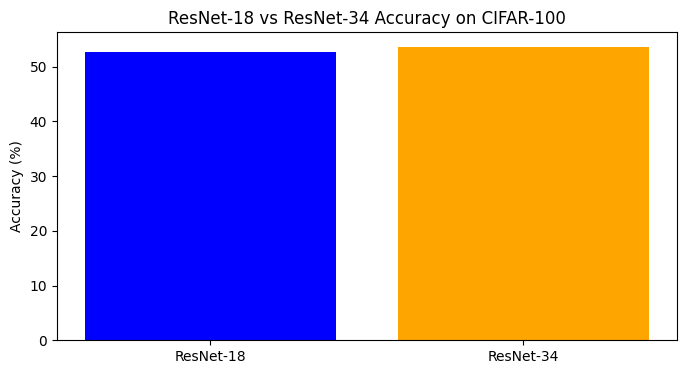

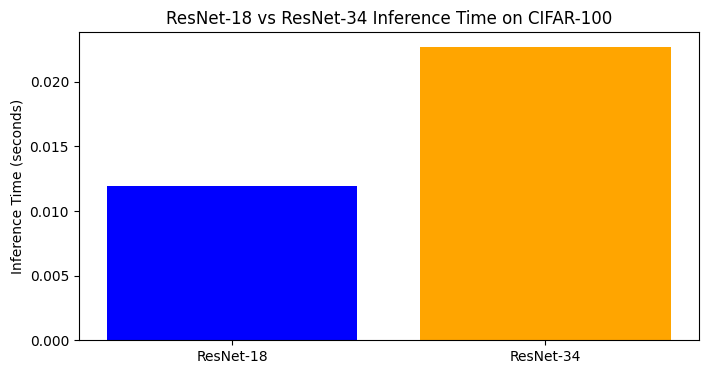

In [27]:
import matplotlib.pyplot as plt


models = ["ResNet-18", "ResNet-34"]
accuracies = [acc_18, acc_34]
times = [time_18, time_34]


plt.figure(figsize=(8, 4))
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.ylabel("Accuracy (%)")
plt.title("ResNet-18 vs ResNet-34 Accuracy on CIFAR-100")
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(models, times, color=['blue', 'orange'])
plt.ylabel("Inference Time (seconds)")
plt.title("ResNet-18 vs ResNet-34 Inference Time on CIFAR-100")
plt.show()
